In [1]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from IPython.display import display, HTML
import matplotlib

## Power analysis
See https://www.overleaf.com/read/jfkkwznjsbxg

In [2]:
originalData = np.array([0.8, 1.1, 0.7, 0.5, -0.1, 0.7])
originalMean = np.mean(originalData)
originalSD = np.std(originalData)

In [3]:
# N.B. all hacky and done quickly
version = '1.0'
load_dir = '../data/human/1.0'
save_dir = load_dir
print(os.listdir(load_dir))
ignore = set(['w86a7f6a', 'we8453df', 'w85a4c6c', 'w93c8b0c', 'wb4d0e59', 'w8fe1e0c', 'w8488b17', 'w2bc1e74'])

dataDF = pd.read_pickle('{}/processed_data.p'.format(save_dir))

['.DS_Store', 'processed_data.p', 'participants.csv', 'html-button-response-filtered.csv', 'html-button-response.csv', 'survey-multi-select.csv', 'processed_data_summary.p', 'html-keyboard-response.csv']


A               5.428571
B               1.607143
C               4.589286
D               2.160714
(D-B)-(C-A)     1.392857
N_max           1.000000
N_min           0.000000
N              28.000000
dtype: float64
A              1.303232
B              1.429563
C              1.650216
D              2.353302
(D-B)-(C-A)    1.701618
dtype: float64


(array([ 2.,  0.,  1.,  1.,  4., 10.,  3.,  4.,  1.,  2.]),
 array([-2.58157708, -2.14082002, -1.70006296, -1.25930589, -0.81854883,
        -0.37779177,  0.06296529,  0.50372236,  0.94447942,  1.38523648,
         1.82599355]),
 <BarContainer object of 10 artists>)

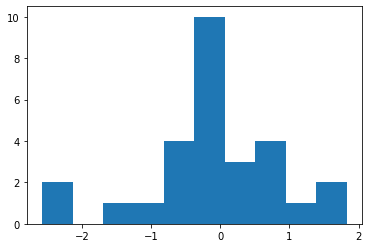

In [4]:
expResults = dataDF[['A', 'B', 'C', 'D', '(D-B)-(C-A)']].mean()
expResults["N_max"] = dataDF["Max"].sum()
expResults["N_min"] = dataDF["Min"].sum()
expResults["N"] = len(dataDF)
print(expResults)
sdResults = dataDF[['A', 'B', 'C', 'D', '(D-B)-(C-A)']].std()
print(sdResults)
Z = (dataDF['(D-B)-(C-A)'].copy() - expResults['(D-B)-(C-A)']) / sdResults['(D-B)-(C-A)']
plt.hist(Z)

In [10]:
from scipy import stats
def return_statistic(alpha, beta, option="z", N=30):
    """Currently assumes two-tailed"""
    if option == "z":
        return (stats.norm.ppf(1-alpha/2), stats.norm.ppf(beta))
    elif option == "t":
        return (stats.t.ppf(1-alpha/2, N-1), stats.t.ppf(beta, N-1))
    else:
        print("Statistic not implemented yet")
        return 
    
def return_p(statistic, option="z", N=30):
    if option == "z":
        return stats.norm.cdf(statistic)
    elif option == "t":
        return stats.t.cdf(statistic, N-1)
    else:
        print("Statistic not implemented yet")
        return 
    
def calculate_sample_size(sigma, mu_A, mu_0=0, b=0.842, a_half=1.96, option="z"):
    """Uses the power calculation from https://cran.r-project.org/web/packages/distributions3/vignettes/one-sample-z-test.html
    to derive an estimate for N"""
    num = sigma*(b - a_half)
    denom = (mu_0-mu_A)
    ESS = np.ceil((num/denom)**2)
    
    if option == "t":
        ESS += 1
    
    return int(ESS)

In [11]:
alpha = 0.05
beta = 0.05
difference = 0.7
sd = 1.701
a_half, b = return_statistic(alpha, beta)
print(a_half, b)
ESS = calculate_sample_size(sd, difference, b=b, a_half=a_half)
print(ESS)

a_half, b = return_statistic(alpha, beta, option="t", N=ESS)
print(a_half, b)
N2 = calculate_sample_size(sd, difference, b=b, a_half=a_half, option="t")
print(N2)

def converge_t_estimate(N_init, alpha, beta, sd, difference):
    Ns = [N_init]
    converged = False

    while not converged:
        a_half_t, b_t = return_statistic(alpha, beta, option="t", N=Ns[-1])
        N_temp = calculate_sample_size(sd, difference, b=b_t, a_half=a_half_t, option="t")
        print(N_temp)
        Ns.append(N_temp)
        converged = Ns[-1] == Ns[-2]

    return Ns

print(converge_t_estimate(N2, alpha, beta, sd, difference))
print(converge_t_estimate(29, alpha, beta, sd, difference))

1.959963984540054 -1.6448536269514729
77
1.9916726093523487 -1.6651513533271274
80
80
[80, 80]
85
80
80
[29, 85, 80, 80]


In [22]:
### Simulation code
def return_dataset(mu, sigma_lit, N):
    """Wrapper"""
    return np.random.normal(loc=mu, scale=sigma_lit, size=N)

def reduce_dataset(samples):
    return (np.mean(samples), np.std(samples), len(samples))

def MC_sim_test_statistic(mu_hat, sigma_hat, N=None, alpha=0.05, mu_0=0, option="z"):
    """Calculate P value and power of our samples"""
    t_stat = (mu_hat - mu_0)/(sigma_hat/ np.sqrt(N-1))
    p_val = 1 - return_p(t_stat, option="t", N=N) + return_p(-t_stat, option=option, N=N)
    
    t_power = (mu_0 - mu_hat) / (sigma_hat / np.sqrt(N-1))
    p1 = return_p(t_power + stats.t.ppf(alpha/2, N-1), option=option, N=N) 
    p2 = 1 - return_p(t_power + stats.t.ppf(1-(alpha/2), N-1), option=option, N=N) 
    power = p1 + p2
    return (p_val, power)

# if using again, switch to below.
def stat_p_val_power(mu_hat, sigma_hat, N=None, alpha=0.05, mu_0=0, option="z"):
    """Calculate P value and power of our sample"""  
    if option=="t":
        stat = (mu_hat - mu_0)/(sigma_hat/ np.sqrt(N-1))
        power = (mu_0 - mu_hat) / (sigma_hat / np.sqrt(N-1))
        p1 = return_p(power + stats.t.ppf(alpha/2, N-1), option=option, N=N) 
        p2 = 1 - return_p(power + stats.t.ppf(1-(alpha/2), N-1), option=option, N=N) 
    elif option=="z":
        stat = (mu_hat - mu_0)/(sigma_hat/ np.sqrt(N))
        power = (mu_0 - mu_hat) / (sigma_hat / np.sqrt(N))
        
        p1 = return_p(power + stats.norm.ppf(alpha/2), option=option, N=N) 
        p2 = 1 - return_p(power + stats.norm.ppf(1-(alpha/2)), option=option, N=N) 
    
    p_val = 1 - return_p(stat, option=option, N=N) + return_p(-stat, option=option, N=N)
    power = p1 + p2
    return (stat, p_val, power)

print(stat_p_val_power(mu, sigma, N=N, option="t"))

In [25]:
max_participants = 200
means = []
for N_temp in np.arange(1, max_participants+1):
    print('\n N is {}'.format(N_temp))
    scores = []
    for i in np.arange(1000):
        scores.append(MC_sim_test_statistic(*reduce_dataset(return_dataset(difference, sd, N=N_temp)), option="z"))
    means.append(np.mean(scores, axis=0))
means = np.array(means)


 N is 1

 N is 2


/var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/ipykernel_91466/325214625.py:11: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = (mu_hat - mu_0)/(sigma_hat/ np.sqrt(N-1))
/var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/ipykernel_91466/325214625.py:14: RuntimeWarning: invalid value encountered in double_scalars
  t_power = (mu_0 - mu_hat) / (sigma_hat / np.sqrt(N-1))



 N is 3

 N is 4

 N is 5

 N is 6

 N is 7

 N is 8

 N is 9

 N is 10

 N is 11

 N is 12

 N is 13

 N is 14

 N is 15

 N is 16

 N is 17

 N is 18

 N is 19

 N is 20

 N is 21

 N is 22

 N is 23

 N is 24

 N is 25

 N is 26

 N is 27

 N is 28

 N is 29

 N is 30

 N is 31

 N is 32

 N is 33

 N is 34

 N is 35

 N is 36

 N is 37

 N is 38

 N is 39

 N is 40

 N is 41

 N is 42

 N is 43

 N is 44

 N is 45

 N is 46

 N is 47

 N is 48

 N is 49

 N is 50

 N is 51

 N is 52

 N is 53

 N is 54

 N is 55

 N is 56

 N is 57

 N is 58

 N is 59

 N is 60

 N is 61

 N is 62

 N is 63

 N is 64

 N is 65

 N is 66

 N is 67

 N is 68

 N is 69

 N is 70

 N is 71

 N is 72

 N is 73

 N is 74

 N is 75

 N is 76

 N is 77

 N is 78

 N is 79

 N is 80

 N is 81

 N is 82

 N is 83

 N is 84

 N is 85

 N is 86

 N is 87

 N is 88

 N is 89

 N is 90

 N is 91

 N is 92

 N is 93

 N is 94

 N is 95

 N is 96

 N is 97

 N is 98

 N is 99

 N is 100

 N is 101

 N is 102

 N 

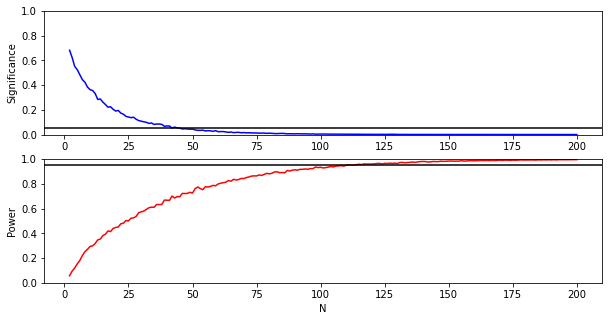

In [27]:
#print(means)
fig, ax = plt.subplots(2, 1, figsize = (10, 5))
ax[0].plot(np.arange(1, max_participants+1), means[:, 0], 'b')
ax[0].set_ylabel('Significance')
ax[0].set_ylim([0, 1])
ax[0].axhline(0.05, color='k')
ax[1].plot(np.arange(1, max_participants+1), means[:, 1], 'r')   
ax[1].set_ylabel('Power')
ax[1].set_xlabel('N')
ax[1].set_ylim([0, 1])

ax[1].axhline(0.95, color='k')